# TensorFlow Network finding

This notebook will work finding the best trade-off for TensorFlow neural network, using previous data transformation

**Main goals are**: 
- Use our understanding blabla



In [42]:
IMAGE_SIZE = [163, 220]

In [43]:
from local_lib.dataset import retreiveDatasetFromCsv
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from local_lib.flatten_transformer import FlattenTransformer
from local_lib.dimension_transformer import DimensionTransformer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

In [48]:
pipeline = Pipeline([
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('minmax', MinMaxScaler())
    ])

In [50]:
# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))


In [51]:
import copy

# Make a copy of the list
y_simpler = copy.deepcopy(y)
y_simpler[y_simpler == 2] = 1
np.unique(y_simpler)

y = y_simpler

In [57]:
print(X.shape)
print(y.shape)

(5856, 35860)
(5856,)


In [54]:
import keras

checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)


In [55]:
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [63]:
#Reshape to 2D
X_reshaped = X.reshape((X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


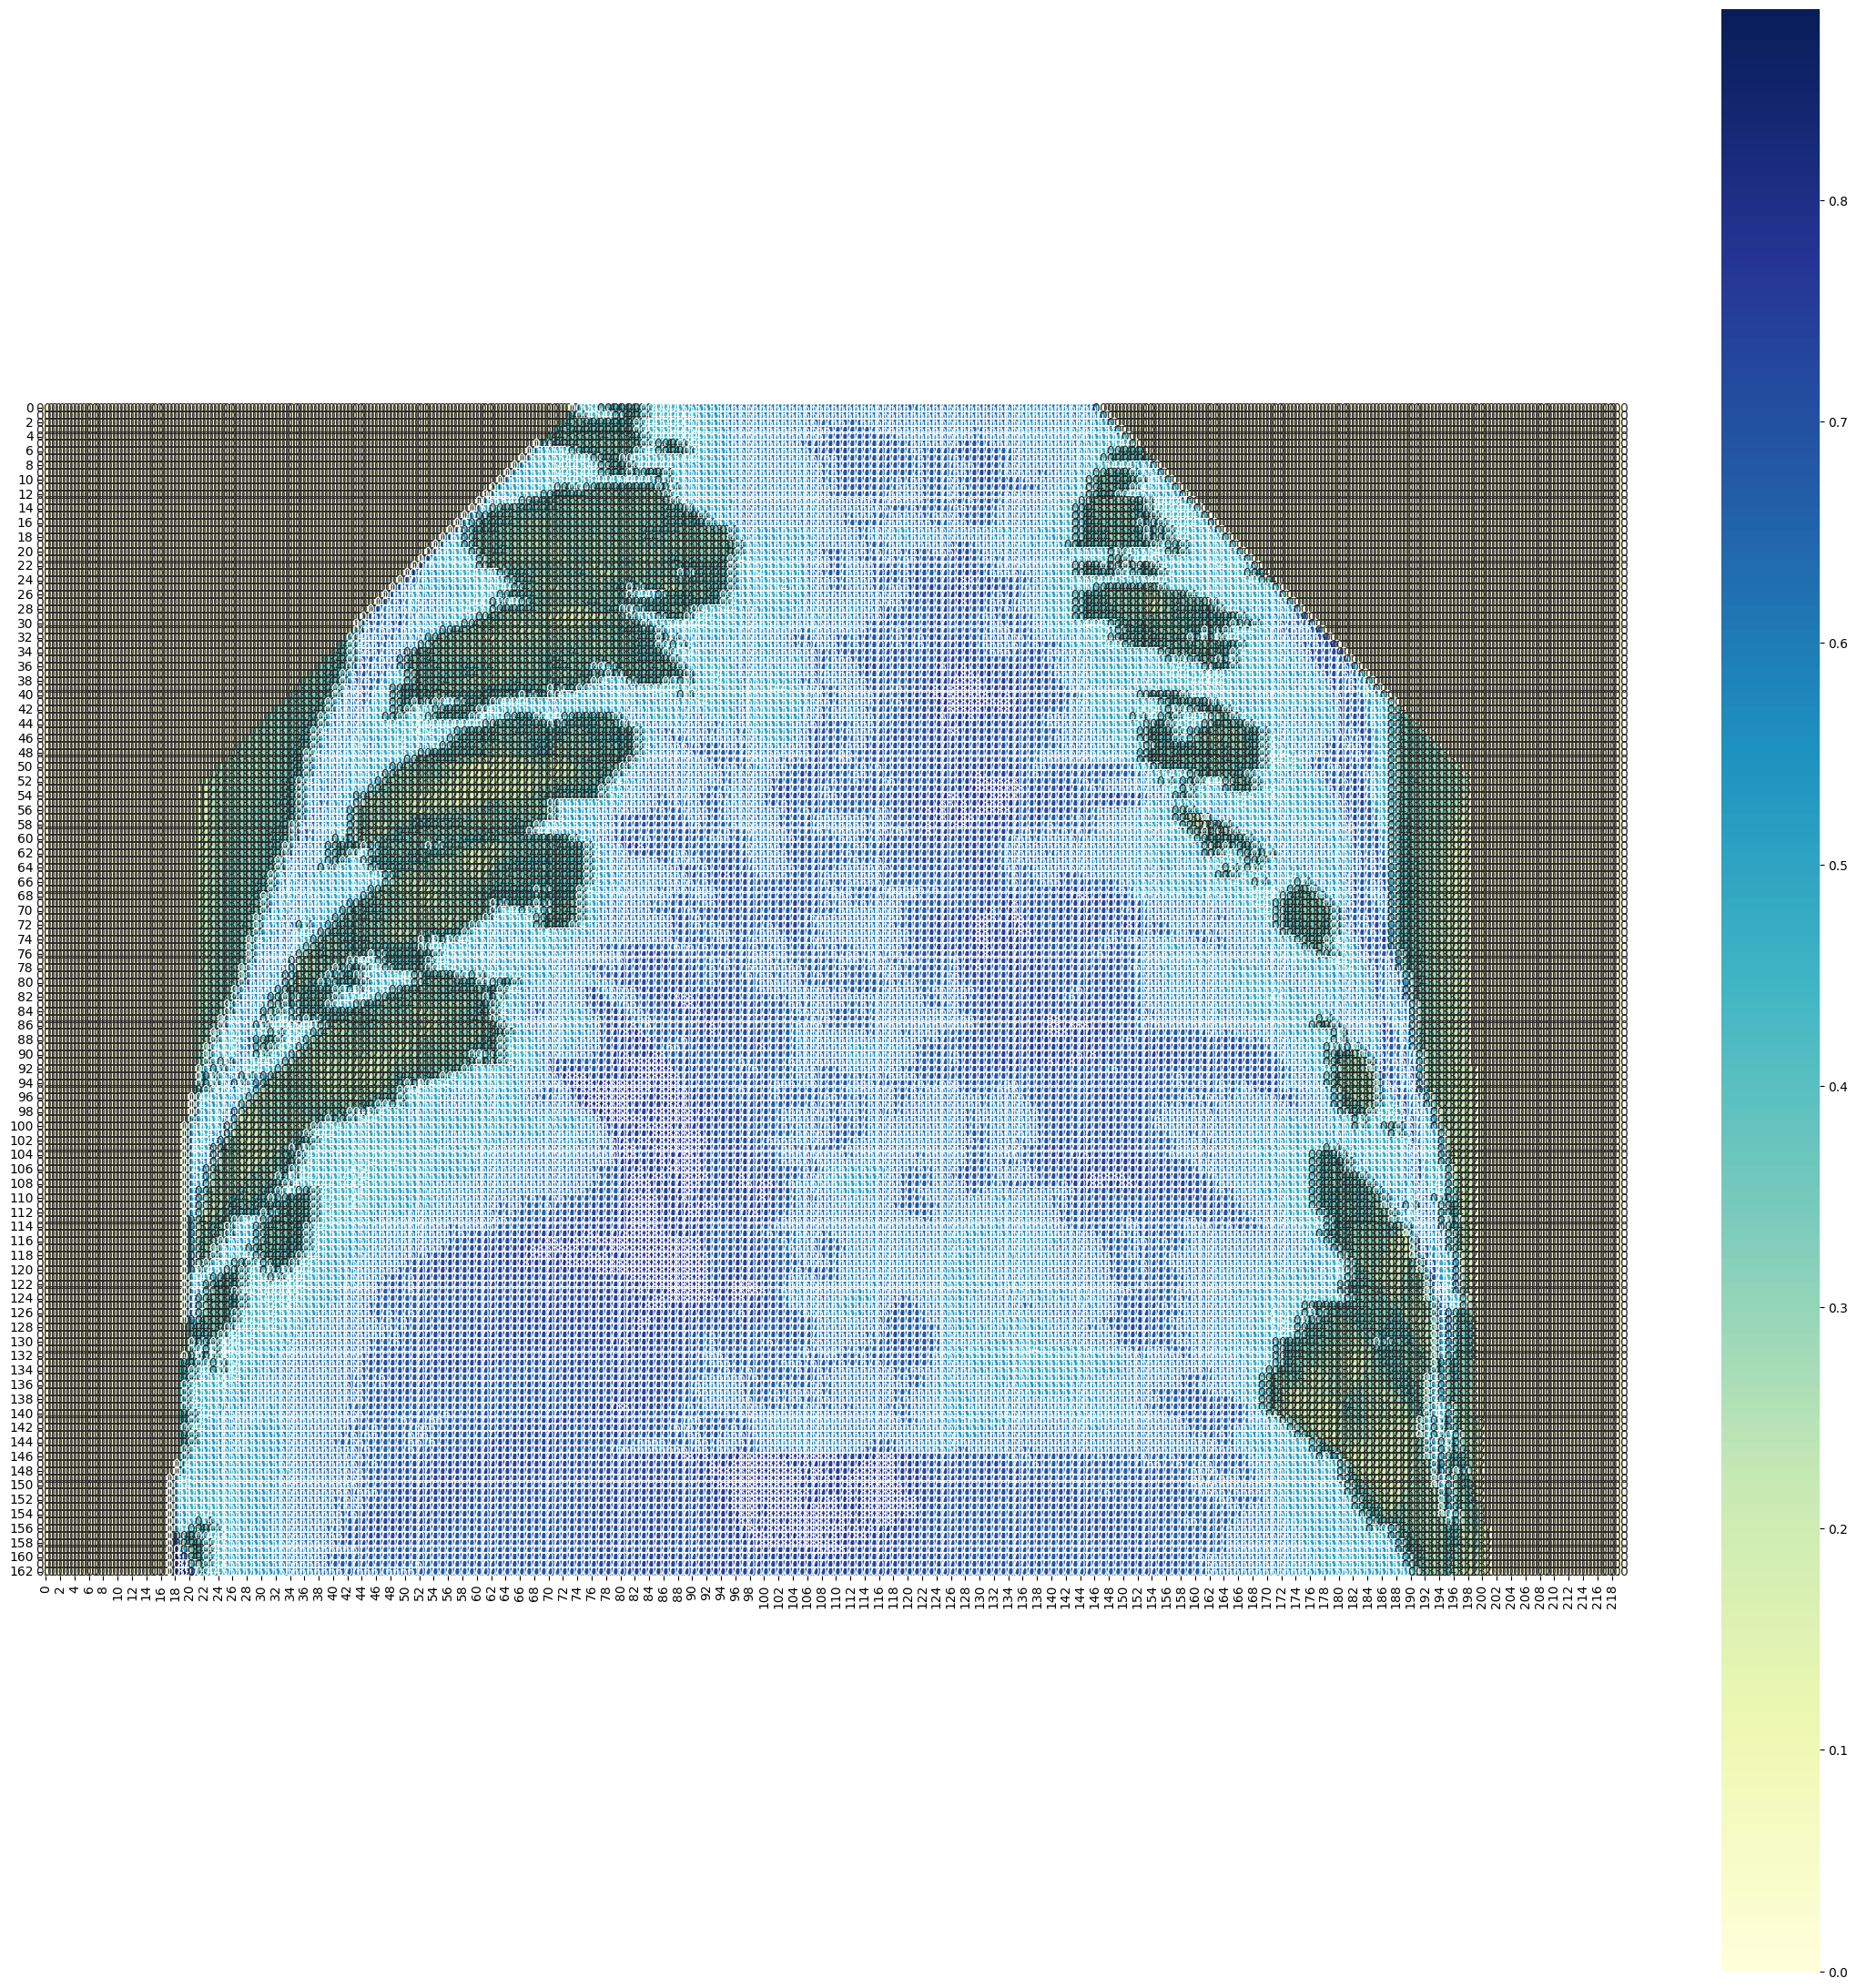

In [70]:
# Using a nice ploting lib
import matplotlib.pyplot as plt

import seaborn as sns

image = X[0].reshape(163,220)
label = y[0]

f, ax = plt.subplots(figsize=(28, 28))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

# Bellow we can have a closer view to what the computer will use as data

In [64]:
X_reshaped.shape

(5856, 163, 220, 1)

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

c:\Users\a910572\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
# Compile the model with the learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
# Train the model with the callbacks
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 53s 441ms/step - accuracy: 0.7431 - loss: 0.7154 - val_accuracy: 0.6980 - val_loss: 0.6192
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 423ms/step - accuracy: 0.7302 - loss: 0.5879 - val_accuracy: 0.6980 - val_loss: 0.6151
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - accuracy: 0.7375 - loss: 0.5758 - val_accuracy: 0.6980 - val_loss: 0.6140
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 411ms/step - accuracy: 0.7478 - loss: 0.5663 - val_accuracy: 0.6980 - val_loss: 0.6131
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 426ms/step - accuracy: 0.7319 - loss: 0.5819 - val_accuracy: 0.6980 - val_loss: 0.6172
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 423ms/step - accuracy: 0.7304 - loss: 0.5833 - val_accuracy: 0.6980 - val_loss: 0.6145
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 420ms/step - accuracy: 0.7348 - loss: 0.5787 - val_accuracy: 0.6980 - val_loss: 0.6153
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 439ms/step - accuracy: 0.7337 - loss: 0

In [79]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7404 - loss: 0.5745


In [80]:
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.7329351305961609
